Converting binary data to netCDF example
=======================

Create a fortran program that reads a binary file and writes it to a netCDF file

In [1]:
%%file test.f90

program example
  use netcdf

  integer, parameter :: n_time = 366
  integer, parameter :: n_lon = 720
  integer, parameter :: n_lat = 360
  real(kind=4), dimension(n_lon, n_lat, n_time) :: outflow
  character(len=*), parameter :: unit = 'm3 s-1'
  ! this is an example dataset from Dai Yamazaki
  character(len=*), parameter :: infile = '/Users/baart_f/data/boulder/dai/hessel/outflw2000.bin'
  character(len=*), parameter :: standard_name = 'water_volume_transport_into_sea_water_from_rivers'
  ! Better is to use a newunit function or newunit option for newer fortrans
  integer :: infile_unit = 100
  ! for looping
  integer :: i, status
  integer :: ncid
  integer :: latdim_id, londim_id, timedim_id
  integer :: outflowvar_id
  ! not your everyday fill value (apprx 1e20)
  real(kind=4) :: fill_value = 100000002004087734272.0

  ! Read the input file in unformatted stream form, as big_endian.
  open(unit=infile_unit, &
       file=trim(infile), &
       form='unformatted', &
       access='stream', &
       iostat=status)
  ! not needed                                                                                                          
  ! convert='big_endian' 
  read(infile_unit) outflow
  close(infile_unit)

  ! create a new file
  status = nf90_create( &
       path="foo.nc", &
       cmode=ior(NF90_CLOBBER,NF90_HDF5), &
       ncid=ncid &
       )
    
  ! define the dimensions
  status = nf90_def_dim(ncid, "lat", n_lat, latdim_id)
  status = nf90_def_dim(ncid, "lon", n_lon, londim_id)
  status = nf90_def_dim(ncid, "time", n_time, timedim_id)
    
  ! define the variables
  status = nf90_def_var(ncid, "outflow", nf90_float, &
       dimids=(/ londim_id, latdim_id, timedim_id /), &
       deflate_level=5, &
       varid=outflowvar_id)
  
  ! add some attributes on the file
  status = nf90_put_att(ncid, 0, 'title', 'Outflow 2000 dataset')
  status = nf90_put_att(ncid, 0, 'institution', 'Japan Agency for Marine-Earth Science and Technology')
  status = nf90_put_att(ncid, 0, 'source', 'CaMa Flood model')
  status = nf90_put_att(ncid, 0, 'resolution', '0.5 degrees')
  status = nf90_put_att(ncid, 0, 'Conventions', 'CF-1.6')
  status = nf90_put_att(ncid, 0, 'history', 'created with test.f90')

  ! add some attributes to the variable
  status = nf90_put_att(ncid, outflowvar_id, '_FillValue', fill_value)
  status = nf90_put_att(ncid, outflowvar_id, 'units', unit)
  status = nf90_put_att(ncid, outflowvar_id, 'standard_name', standard_name)
    
  ! we have defined the variables  
  status = nf90_enddef(ncid)
    
  ! now we can write the data
  status = nf90_put_var(ncid, outflowvar_id, outflow)
    
  ! and done
  status = nf90_close(ncid=ncid)


end program example


Overwriting test.f90


Compile and link the fortran program

In [2]:
%%bash 
gfortran -c -ffree-line-length-none -ffree-form -I/opt/local/include test.f90
gfortran -L/opt/local/lib test.o -lnetcdf -lnetcdff -o test



Check what we created

In [3]:
%%bash
./test
ncdump -h foo.nc
ls -alh foo.nc  /Users/baart_f/data/boulder/dai/hessel/outflw2000.bin

netcdf foo {
dimensions:
	lat = 360 ;
	lon = 720 ;
	time = 366 ;
variables:
	float outflow(time, lat, lon) ;
		outflow:_FillValue = 1.e+20f ;
		outflow:units = "m3 s-1" ;
		outflow:standard_name = "water_volume_transport_into_sea_water_from_rivers" ;

// global attributes:
		:title = "Outflow 2000 dataset" ;
		:institution = "Japan Agency for Marine-Earth Science and Technology" ;
		:source = "CaMa Flood model" ;
		:resolution = "0.5 degrees" ;
		:Conventions = "CF-1.6" ;
		:history = "created with test.f90" ;
}
-rw-r--r--@ 1 baart_f  staff   362M Apr 22 09:03 /Users/baart_f/data/boulder/dai/hessel/outflw2000.bin
-rw-r--r--  1 baart_f  staff    77M May  6 06:57 foo.nc


Read what we just wrote

In [4]:
import numpy as np
import netCDF4
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
var = netCDF4.Dataset('foo.nc').variables['outflow']

In [6]:
var.dimensions
var[0,0,0]

masked_array(data = --,
             mask = True,
       fill_value = 1e+20)

/Users/baart_f/.virtualenvs/main/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from IPython.kernel.zmq import kernelapp as app
/Users/baart_f/.virtualenvs/main/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from IPython.kernel.zmq import kernelapp as app


<matplotlib.colorbar.Colorbar instance at 0x107bf54d0>

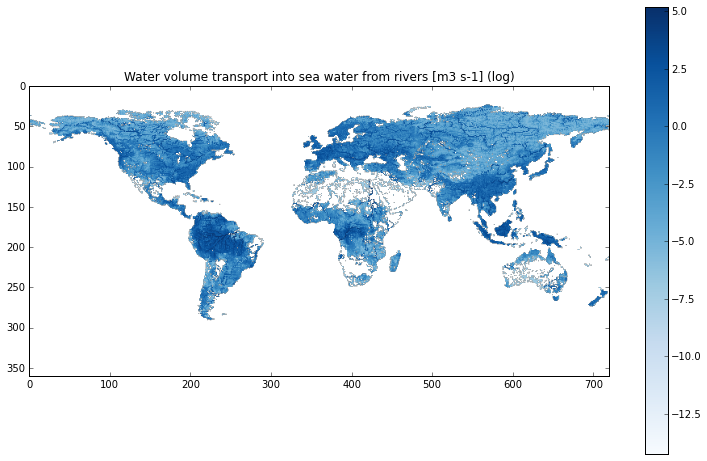

In [7]:
fig, ax = plt.subplots(figsize=(13,8))
im = ax.imshow(np.log10(var[0]), cmap='Blues')
name = var.standard_name.replace('_', ' ').capitalize()
unit = var.units
title = "{name} [{unit}] (log)".format(**locals()) 
ax.set_title(title)
plt.colorbar(im, ax=ax)